# **Create Automated Data Pipline with Airflow and Big Query**

#**1.Importing Modules**

In [ ]:
from airflow import DAG
from airflow.operators.bash_operator import BashOperator
from airflow.operators.python_operator import PythonOperator
from airflow.utils.dates import days_ago
from datetime import timedelta

import pymysql.cursors
import pandas as pd
import requests



In [ ]:
class Config:
    MYSQL_HOST = 'db4free.net'
    MYSQL_PORT = 3306
    MYSQL_USER = gongjun[0].strip()
    MYSQL_PASSWORD = gongjun[1].strip()
    MYSQL_DB = 'de_ayp'
    MYSQL_CHARSET = 'utf8mb4'


In [ ]:
#For PythonOperator

In [ ]:
def get_data_from_db():

    # Connect to the database
    connection = pymysql.connect(host=Config.MYSQL_HOST,
                                port=Config.MYSQL_PORT,
                                user=Config.MYSQL_USER,
                                password=Config.MYSQL_PASSWORD,
                                db=Config.MYSQL_DB,
                                charset=Config.MYSQL_CHARSET,
                                cursorclass=pymysql.cursors.DictCursor)

In [ ]:
    with connection.cursor() as cursor:
        # Read a single record
        sql = "SELECT * from online_retail"
        cursor.execute(sql)
        result_retail = cursor.fetchall()



In [ ]:
retail = pd.DataFrame(result_retail)
    retail['InvoiceTimestamp'] = pd.to_datetime(retail['InvoiceDate'])
    retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate']).dt.date
    retail.to_csv("/home/airflow/gcs/data/retail_from_db.csv", index=False)


In [ ]:
def get_data_from_api():
    url = "https://de-training-2020-7au6fmnprq-de.a.run.app/currency_gbp/all"
    response = requests.get(url)
    result_conversion_rate = response.json()

    conversion_rate = pd.DataFrame.from_dict(result_conversion_rate)
    conversion_rate = conversion_rate.reset_index().rename(columns={"index":"date"})

    conversion_rate['date'] = pd.to_datetime(conversion_rate['date']).dt.date
    conversion_rate.to_csv("/home/airflow/gcs/data/conversion_rate_from_api.csv", index=False)


In [ ]:
def convert_to_thb():
    retail = pd.read_csv("/home/airflow/gcs/data/retail_from_db.csv")
    conversion_rate = pd.read_csv("/home/airflow/gcs/data/conversion_rate_from_api.csv")
    
    final_df = retail.merge(conversion_rate, how="left", left_on="InvoiceDate", right_on="date")

    final_df['THBPrice'] = final_df.apply(lambda x: x['UnitPrice'] * x['Rate'], axis=1)
    final_df.to_csv("/home/airflow/gcs/data/result.csv", index=False)


# **2. Default Arguments**

In [ ]:
# Default Args

default_args = {
    'owner': 'datath',
    'depends_on_past': False,
    'start_date': days_ago(1),
    'email': ['airflow@example.com'],
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
    'schedule_interval': '@once',
}


# **3. Instantiate a Dag**

In [ ]:
# Create DAG

dag = DAG(
    'online_retail_w5',
    default_args=default_args,
    description='Pipeline for ETL online_retail data',
    schedule_interval=timedelta(days=1),
)


# **4. Tasks**

In [ ]:
# db_ingest
t1 = PythonOperator(
    task_id='db_ingest',
    python_callable=get_data_from_db,
    dag=dag,
)

# api_call
t2 = PythonOperator(
    task_id='api_call',
    python_callable=get_data_from_api,
    dag=dag,
)

# convert_currency
t3 = PythonOperator(
    task_id='convert_currency',
    python_callable=convert_to_thb,
    dag=dag,
)

# TODO: load to BigQuery
t4 = BashOperator(
    task_id='bq_load',
    bash_command='bq load --source_format=CSV --autodetect \
            online_retail.online_retail \
            gs://australia-southeast1-projec-5f88355a-bucket/data/result.csv',
    dag=dag,
)


# **5. Setting up Dependencies**

In [ ]:
[t1, t2] >> t3 >> t4

# **ETL Process (defined and visualised via Airflow DAG)**
The DAG:

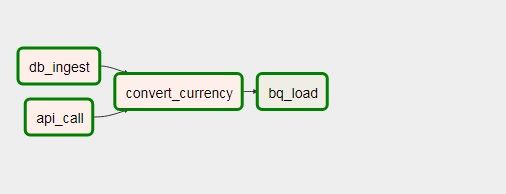

# **Big Query: Query Report Data**


In [ ]:
SELECT *
FROM 'Project-r2de.online_retail.online_retail'


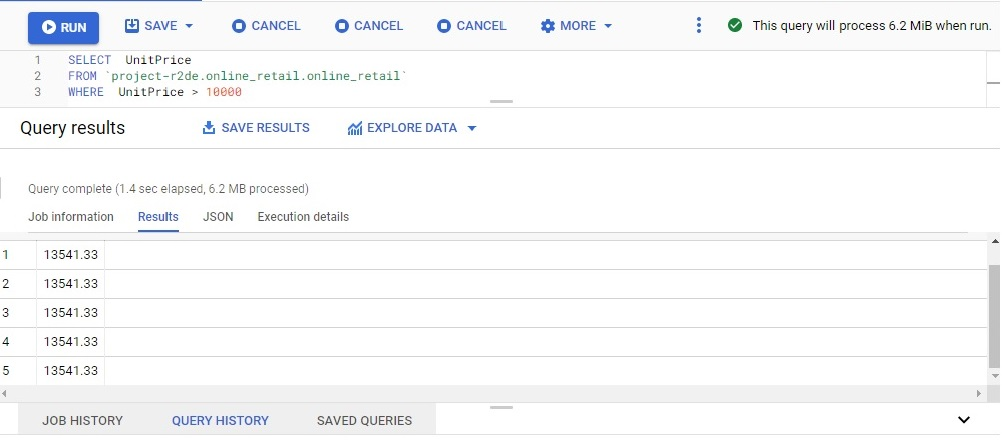